#Detecção da originalidade cromática de aplicativos usando Deep Learning

### Inicialização

In [ ]:
#Jupyter configs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#Verificando qual GPU o Colab disponibilizou
!/opt/bin/nvidia-smi
!nvcc --version

Thu Mar 17 17:35:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importação de todos os pacotes necessários. 

Biblioteca [fastai V1](http://www.fast.ai/2018/10/02/fastai-ai/), que fica em cima do [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163).

In [ ]:
#Imports de bibliotecas necessárias DL
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

# Imports de bibliotecas necessárias de utilidades
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern # Para as definições de símbolos
import os

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

###Conjunto de dados

Podem ser upados no notebook ou usados a partir do Google Drive.

In [ ]:
# Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Carregamento dados de treinamento
local = r'/content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Treinamento'

df = pd.DataFrame(columns=['ID_image','filename','class'])
i = 0
for path in Path(local).rglob('*.png'):
    filename = str(path).split(os.sep)[len(str(path).split(os.sep))-1]
    class_name = str(path).split(os.sep)[len(str(path).split(os.sep))-2]
    df.at[i, 'ID_image'] = filename.split('.png')[0]
    df.at[i, 'filename'] = class_name + os.sep + filename
    df.at[i, 'class'] = str(path).split(os.sep)[len(str(path).split(os.sep))-2]
    i = i + 1
df

,ID_image,filename,class
0,Pikachu_1,original/Pikachu_1.png,original
1,4507115263885312_10,original/4507115263885312_10.png,original
2,4536753883185152_7,original/4536753883185152_7.png,original
3,4536753883185152_2,original/4536753883185152_2.png,original
4,4536753883185152_4,original/4536753883185152_4.png,original
...,...,...,...
143,InfoCarvalhal_6,nada_original/InfoCarvalhal_6.png,nada_original
144,InfoCarvalhal_7,nada_original/InfoCarvalhal_7.png,nada_original
145,5420291046768640-1,nada_original/5420291046768640-1.png,nada_original
146,InfoCarvalhal_1,nada_original/InfoCarvalhal_1.png,nada_original


In [ ]:
#Vendo quanto temos de cada classe
df['class'].value_counts()

nada_original             54
mais_ou_menos_original    48
original                  46
Name: class, dtype: int64

In [ ]:
#Fazendo um shuffle no dataframe para ficar ordenado aleatoriamente
df = df.sample(frac=1)

###Criando data bunches

In [ ]:
bs = 2 #usanod um número pequeno porque o conjunto é pequeno
valid_pct = 0.2 #80% treino 20% validação

data = ImageDataBunch.from_df("/content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Treinamento",
                              df=df,
                              fn_col="filename",
                              label_col="class",
                              valid_pct=valid_pct,
                              size=(1920, 1080),
                              bs=bs).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (119 items)
x: ImageList
Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080)
y: CategoryList
nada_original,mais_ou_menos_original,original,original,original
Path: /content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Treinamento;

Valid: LabelList (29 items)
x: ImageList
Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080)
y: CategoryList
mais_ou_menos_original,nada_original,nada_original,nada_original,original
Path: /content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Treinamento;

Test: None

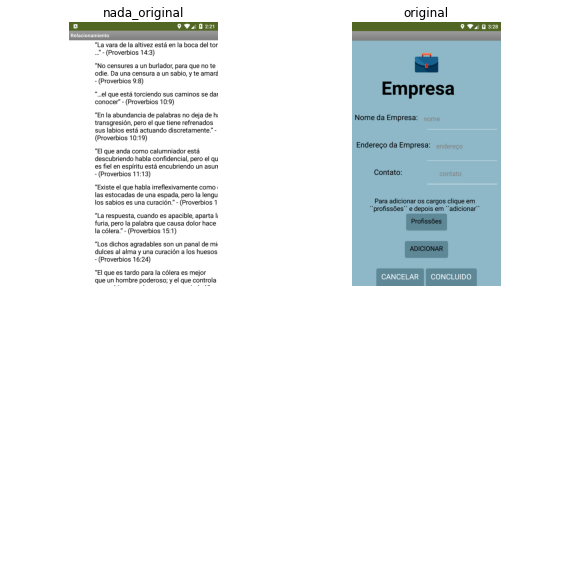

In [ ]:
#Visualizando como ficou com uma imagem
#data.show_batch(rows=2, figsize=(5,10))
data.show_batch(nrows=2)

In [ ]:
print(data.classes)
len(data.classes),data.c

['mais_ou_menos_original', 'nada_original', 'original']


(3, 3)

## Primeiro experimento de treinamento: ResNet34

###Treinamento com resnet34 - Criação do learn

* A função cnn_learner tem como parâmetros os dados (data), a arquitetura (resnet34)
e a métrica ([accuracy, error_rate])

  * O argumento 'data' contém a instância do DataBunch.
O fast.ai adapta automaticamente a camada de entrada da nova rede à resolução
de imagem mais alta.

  * A arquitetura nada mais é que uma função matemática que será otimizada. 
Aqui estamos usando ResNet, que é uma arquitetura muito boa para problemas
de visão computacional. O número 34 indica quantas camadas ela tem. É possível
usar mais camadas, porém isso demorá mais para treinar e precisará de mais 
memória. No entanto, mais camadas permitem criar modelos bem complexos.
O learner tentará descobrir quais parâmetros que melhor fazem com que os dados
casem (match) com os labels.
Em uma primeira execução é feito o download da rede ResNet34 com pesos pré-treinados, isto é, com o modelo já treinado para uma tarefa usando imagens do ImageNet. Isso é chamado de aprendizado por transferência.

  * As métricas serão usadas com o conjunto de validação e mostradas a cada época (olhar 1x para todas as imagens do dataset). Consistem em funções que medem a qualidade de predição do modelo usando o conjunto de validação. Aqui estamos usando duas métricas de erro: acurácia e taxa de erro. A taxa de erro diz a porcentagem de imagens no conjunto de validação que estão sendo classificadas incorretamente.
Lembrando que são complementares: acurácia = 1 – taxa de erro.

OBS: acurácia e taxa de erro são coisas diferentes de loss. Loss é relacionado a quão bem o modelo está indo quando mudamos um pouco os parâmetros do modelo. Isso não representa a acurácia, pois é possível mudar os parâmetros do modelo por um valor pequeno e ainda obter a mesma acurácia. Loss e métrica são relacionados, porém métrica é algo que usamos e loss é algo que o computador usa como medida de performance para decidir como atualizar os parâmetros.

OBS2: Aprendizado por transferência permite treinar modelos em 1/100 ou até mesmo 1/1000 do tempo que um treinamento regular precisaria.

OB3: As métricas são calculadas sobre os dados de validação, que são os dados que o modelo nunca verá durante o treinamento.

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Treinamento do modelo usando 4 épocas (4 ciclos através de todos os dados).
* Overfitting: não basta que o modelo faça predições exatas para dados no qual foi treinado e predições não tão boas em dados que nunca viu. Afinal, esses são os dados que realmente importam na prática.

In [ ]:
#Aprendizado por transferência
#fit_one_cycle: possui otimização de hiperparâmetros
# X épocas => passar x os dados
# OBS: se conseguir menos de 10% de erro em transfer learning já é algo bom
# É difícil manter menos de 10% ao fazer fine tuning
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.531241,0.887723,0.655172,0.344828,01:14
1,1.369732,0.907730,0.655172,0.344828,01:06
2,1.468850,0.842438,0.758621,0.241379,01:06
3,1.212719,1.080719,0.620690,0.379310,01:06


In [ ]:
#Salvando a rede para uso posterior
learn.save('stage-1')

### Resultados

####Visualizando se os erros que o modelo está cometendo via *matriz de confusão*.

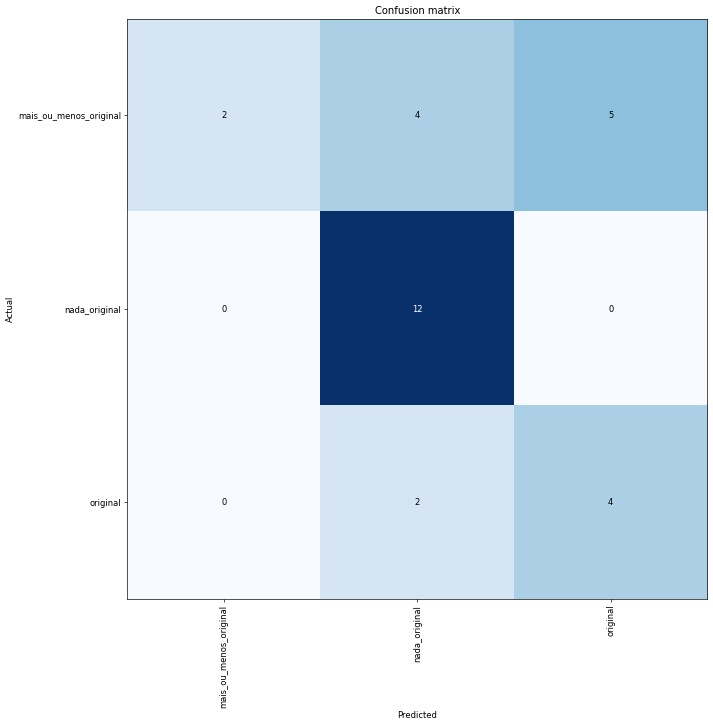

In [ ]:
#Primeiro é necessário gerar um interpretador
#Simplesmente vai jogar tudo de novo e classificar todos os dados
interp = ClassificationInterpretation.from_learner(learn)

#Matriz de confusão
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

As linhas representam screenshots mais ou menos original, nada original e original no conjunto de dados, respectivamente. 

As colunas representam as imagens que o modelo previu como mais ou menos original, nada original e original no conjunto de dados, respectivamente.

Assim, a diagonal da matriz mostra as imagens que foram classificadas corretamente e as células fora da diagonal representam aquelas que foram classificadas incorretamente. 

O classificador de originalidade está cometendo alguns erros entre mais ou menos original x original e x nada original.

É útil ver onde exatamente os erros estão ocorrendo, para ver se eles são devidos a um problema de conjunto de dados ou um problema de modelo.

####Visualização das imagens por sua *perda*.

A perda é um número que é maior se o modelo estiver incorreto (especialmente se também estiver confiante em sua resposta incorreta) ou se estiver correto, mas não tiver certeza de sua resposta correta.

 `plot_top_losses` mostra as imagens com maior perda no conjunto de dados. Como o título da saída diz, cada imagem é rotulada com quatro coisas: previsão, real (rótulo de destino), perda e "probabilidade". A *"probabilidade"* é o nível de confiança, de zero a um, que o modelo atribuiu à sua previsão:

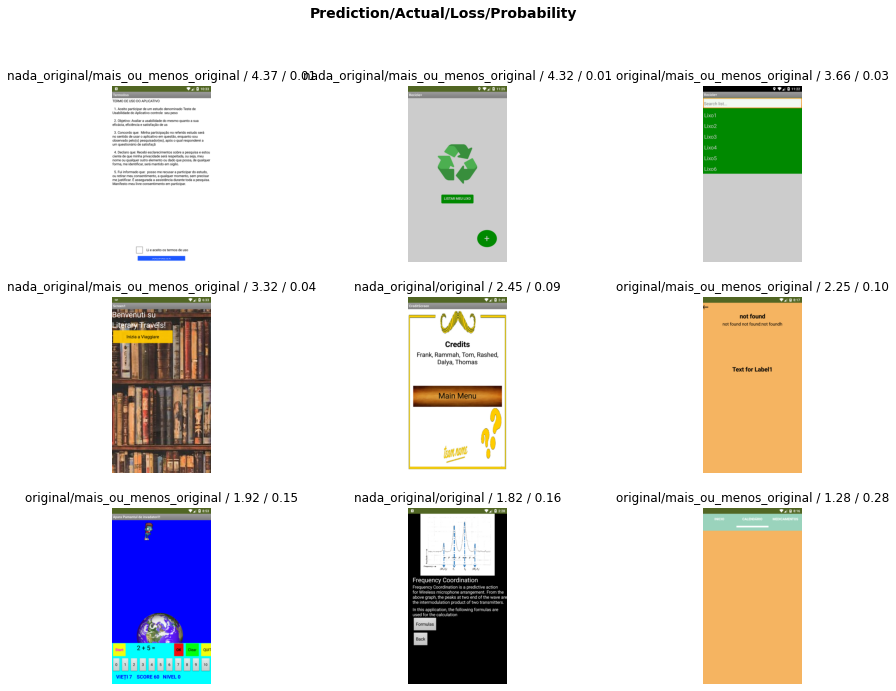

In [ ]:
#Olhando os piores resultados
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=2)

[('mais_ou_menos_original', 'original', 5),
 ('mais_ou_menos_original', 'nada_original', 4),
 ('original', 'nada_original', 2)]

A saída mostra que a imagem com a maior perda é aquela que foi prevista como "original" com alta confiança. No entanto, é rotulado como "mais ou menos original". 

Dependendo da distribuição de cores e opinião de especialistas esse rótulo pode estar incorreto.

### Descongelamento, fine-tuning, e taxa de aprendizagem

In [ ]:
#Descongelamento
learn.unfreeze()

In [ ]:
#Não carreguei os pesos antes, simplesmente descongelei a rede
#Testa uma gama de taxas de aprendizado e valores de momento que fazem sentido
#Função demorada mas vale a pena
#Isso aqui mexe com a rede e não dá mais para usá-la, por isso salvamos os pesos
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 9.12E-08


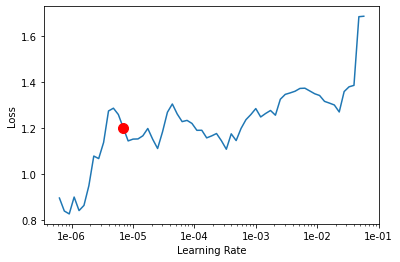

In [ ]:
#Indica valor mínimo do valor da taxa de aprendizagem
#Valores menores que o mínimo são lixos
#Um pouco de pajelância:
#   Tipicamente pegamos o valor mínimo como um ponto do intervalo
#   e duas ordens de grandeza acima como outro ponto do intervalo
learn.recorder.plot(suggestion=True)

In [ ]:
#Necessário carregar os pesos salvos antes, pois o learning find mexeu na rede
learn.load('stage-1')

#Descongela a rede
learn.unfreeze()

#Treina a rede inteira e não apenas a rede backpropagation de saída
#Isso demora
#max_lr => maximum learning rate
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.479650,1.697164,0.551724,0.448276,00:31
1,1.180011,1.441648,0.586207,0.413793,00:31


###Fazendo uma predição

In [ ]:
from fastai.vision.image import open_image

path_image_predict = r'/content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Teste/original/sos_1.jpg'
image_predict = open_image(path_image_predict)
result = learn.predict(image_predict)
result[0]

Category tensor(1)

In [ ]:
pd.DataFrame([result[0]])

,0
0,nada_original


That's a pretty accurate model!

## Training: resnet50

Treinamento com resnet50 (50 camadas).

Geralmente resnet50 funciona melhor porque é uma rede mais profunda com mais parâmetros.

In [ ]:
bs = 2

data_res50 = ImageDataBunch.from_df("/content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Treinamento",
                              df=df,
                              fn_col="filename",
                              label_col="class",
                              valid_pct=0.2,
                              size=(1920, 1080),
                              bs=bs).normalize(imagenet_stats)
data_res50

ImageDataBunch;

Train: LabelList (119 items)
x: ImageList
Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080)
y: CategoryList
original,mais_ou_menos_original,mais_ou_menos_original,mais_ou_menos_original,mais_ou_menos_original
Path: /content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Treinamento;

Valid: LabelList (29 items)
x: ImageList
Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080),Image (3, 1920, 1080)
y: CategoryList
original,nada_original,original,mais_ou_menos_original,original
Path: /content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Treinamento;

Test: None

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


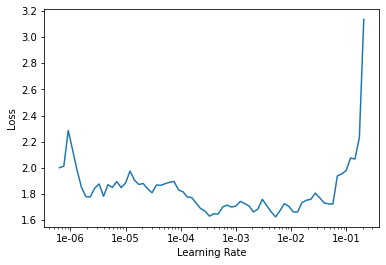

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.663154,1.749998,0.413793,00:40
1,1.537337,1.330695,0.344828,00:40
2,1.419525,1.287961,0.379310,00:40
3,1.299771,1.072827,0.241379,00:40


In [ ]:
learn.save('stage-1-50')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.132443,1.106831,0.241379,00:53
1,1.042560,1.137754,0.275862,00:53
2,1.143940,1.014402,0.344828,00:53


Como ficou ruim, voltando para o primeiro

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('mais_ou_menos_original', 'original', 4), ('original', 'nada_original', 2)]

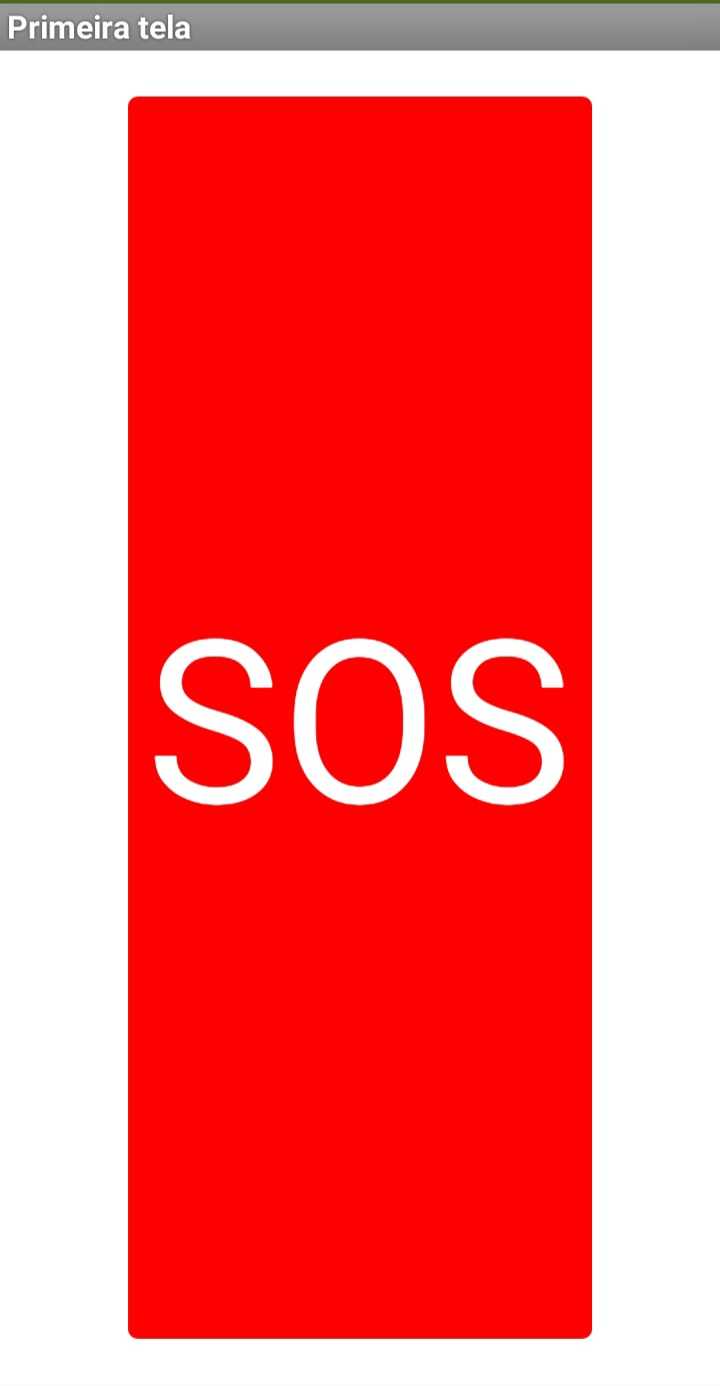

In [ ]:
local = r'/content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Teste/original/sos_1.jpg'
img = cv2.imread(local)
cv2_imshow(img)

In [ ]:
path_image_predict = local
image_predict = open_image(path_image_predict)
result = learn.predict(image_predict)
result

(Category tensor(1), tensor(1), tensor([0.3693, 0.4728, 0.1578]))

In [ ]:
pd.DataFrame([result[0]])

,0
0,nada_original


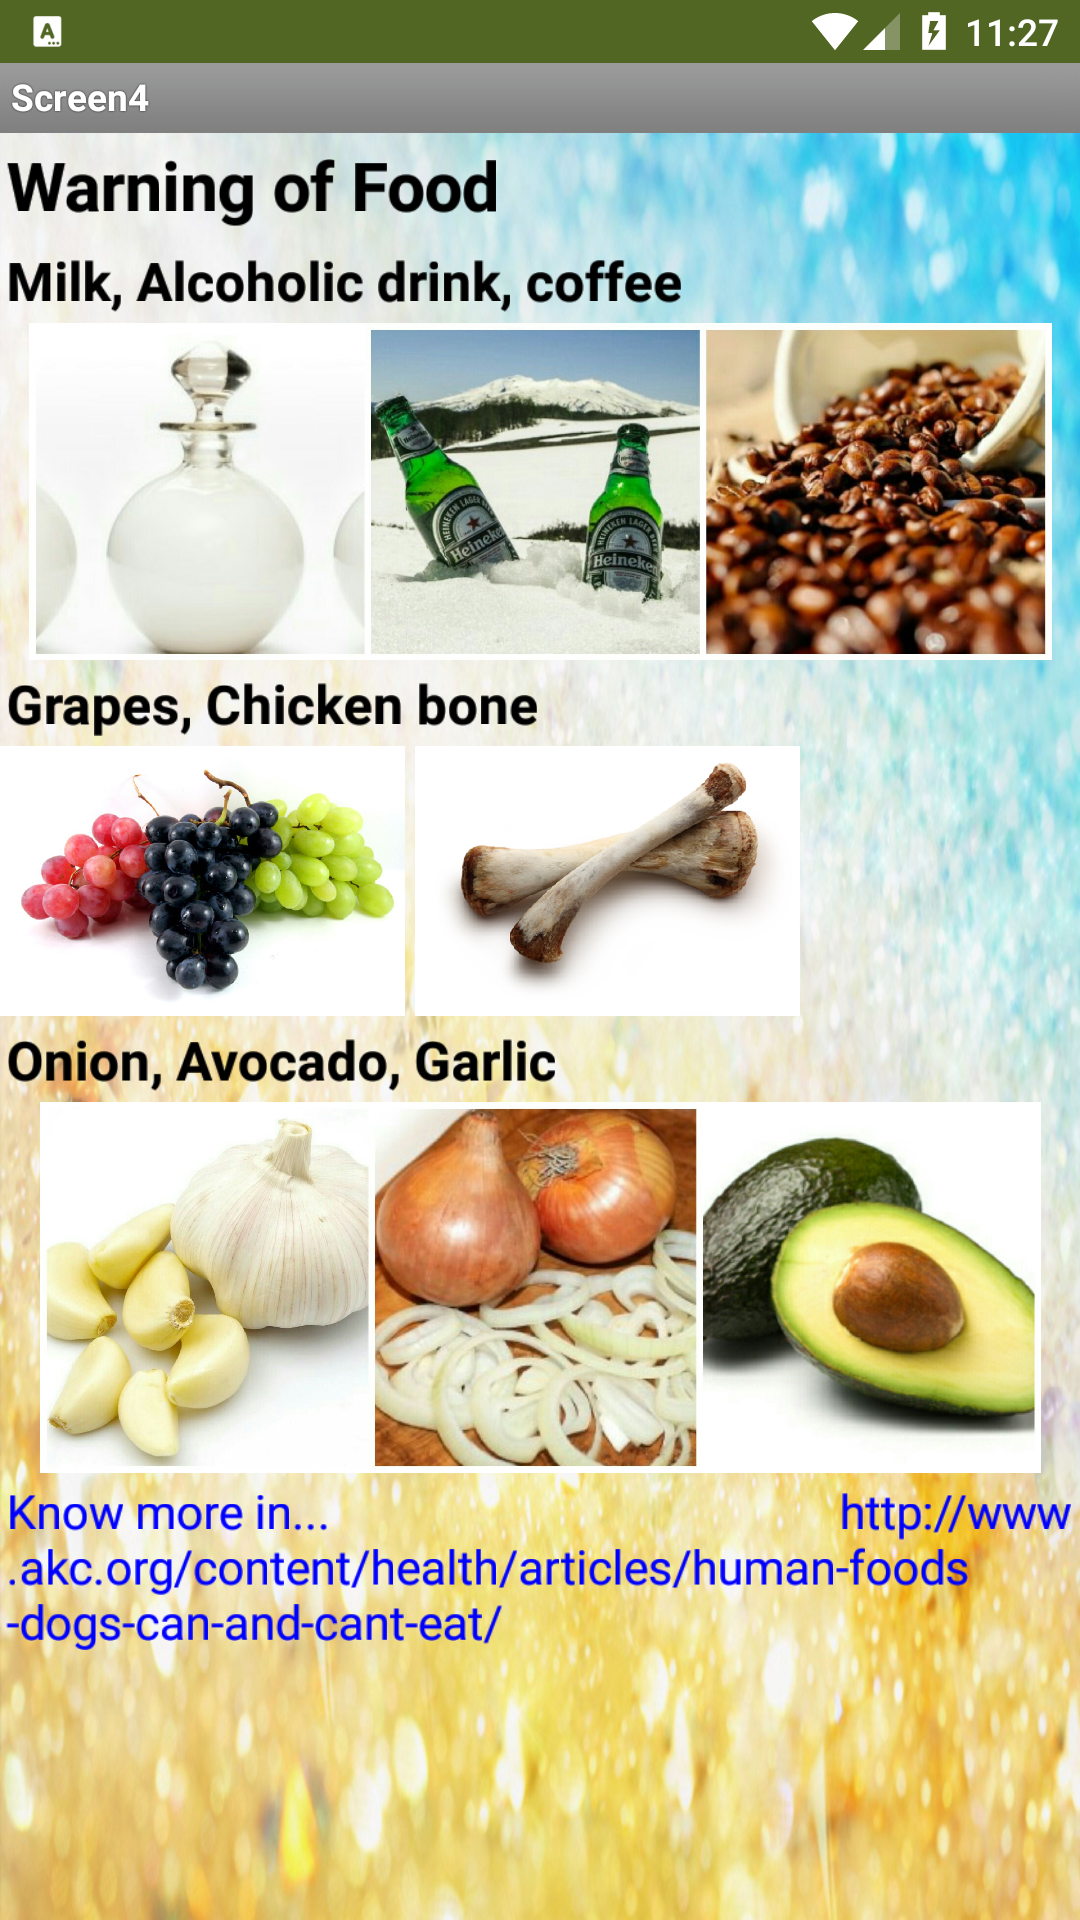

(Category tensor(2), tensor(2), tensor([0.3321, 0.1729, 0.4951]))

In [ ]:
local = r'/content/gdrive/MyDrive/Doutorado/Disciplinas/Visao_Computacional/Projeto_Cores/Imagens/Teste/original/6235597826686976_7.png'

img = cv2.imread(local)
cv2_imshow(img)

path_image_predict = local
image_predict = open_image(path_image_predict)
result = learn.predict(image_predict)
result

In [ ]:
pd.DataFrame([result[0]])

,0
0,original


# Créditos

Esta é uma cópia do notebook apresentado por Jeremy Howards no curso fast.ai V3. Usado também na disciplina de Visão Computacional/UFSC do professor Aldo von Wangenheim.

von Wangenheim, A. 2019. Deep Learning for Diagnosis of Skin Images with fastai. Disponível em: https://towardsdatascience.com/deep-learning-for-diagnosis-of-skin-images-with-fastai-792160ab5495

![banner Creative Commons INCoD UFSC](https://lapix.ufsc.br/wp-content/uploads/2019/05/cc.png)
